In [116]:
import pandas as pd

df = pd.read_csv(r"P:\SSM project\Datasets\Server_logs\CIDDS-001-external-week1.csv")
df.columns = df.columns.str.strip()
df = df.drop(columns=['attackType'])
df = df.drop(columns=['attackID'])
df = df.drop(columns=['attackDescription'])

print(df.head())


           Date first seen   Duration  Proto    Src IP Addr  Src Pt  \
0  2017-03-14 17:43:57.172  81412.697  TCP       EXT_SERVER    8082   
1  2017-03-14 17:43:57.172  81412.697  TCP    OPENSTACK_NET   56978   
2  2017-03-14 17:43:26.135  81504.787  TCP       EXT_SERVER    8082   
3  2017-03-14 17:43:26.135  81504.787  TCP    OPENSTACK_NET   56979   
4  2017-03-14 18:17:09.005  82100.692  TCP       EXT_SERVER    8082   

     Dst IP Addr   Dst Pt  Packets     Bytes  Flows   Flags  Tos   class  
0  OPENSTACK_NET  56978.0     3057     2.1 M      1  .AP...    0  normal  
1     EXT_SERVER   8082.0     4748     2.5 M      1  .AP...    0  normal  
2  OPENSTACK_NET  56979.0     8639     9.1 M      1  .AP...    0  normal  
3     EXT_SERVER   8082.0    12024    10.3 M      1  .AP...    0  normal  
4  OPENSTACK_NET  51649.0    11012    27.2 M      1  .AP.S.    0  normal  


In [117]:
def convert_bytes(x):
    x = str(x).strip()
    if 'M' in x:
        return float(x.replace('M', '').strip()) * 1_000_000
    elif 'K' in x:
        return float(x.replace('K', '').strip()) * 1_000
    else:
        return float(x)
    
df['Bytes'] = [convert_bytes(i) for i in df['Bytes']]


In [118]:
from sklearn.preprocessing import LabelEncoder

cols_to_encode = ['Proto', 'Flags', 'Src IP Addr', 'Dst IP Addr', 'class']
encoders = {}

for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le 


In [119]:
le = LabelEncoder()
le.fit(['UDP', 'TCP', 'ICMP'])
print(le.transform(['TCP'])) 

[1]


In [120]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [121]:
print(df.head())

           Date first seen  Duration  Proto  Src IP Addr    Src Pt  \
0  2017-03-14 17:43:57.172  0.156680      2        10537  0.123323   
1  2017-03-14 17:43:57.172  0.156680      2        10538  0.869429   
2  2017-03-14 17:43:26.135  0.156857      2        10537  0.123323   
3  2017-03-14 17:43:26.135  0.156857      2        10538  0.869444   
4  2017-03-14 18:17:09.005  0.158004      2        10537  0.123323   

   Dst IP Addr    Dst Pt   Packets     Bytes  Flows  Flags  Tos  class  
0        10477  0.869429  0.089527  0.032407    0.0     20    0      0  
1        10476  0.123323  0.139065  0.038580    0.0     20    0      0  
2        10477  0.869444  0.253054  0.140432    0.0     20    0      0  
3        10476  0.123323  0.352219  0.158950    0.0     20    0      0  
4        10477  0.788113  0.322572  0.419753    0.0     21    0      0  


In [139]:
# Separate features and labels
X = df.drop(columns=['class'])
y = df['class']

In [143]:
X = X.drop(columns=["time_window"])
X_scaled = scaler.fit_transform(X)


In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [145]:
import networkx as nx

G = nx.DiGraph()

for _, row in df.iterrows():
    src = row['Src IP Addr']
    dst = row['Dst IP Addr']
    
    edge_data = {
        'proto': row['Proto'],
        'bytes': row['Bytes'],
        'packets': row['Packets'],
        'flags': row['Flags'],
        'duration': row['Duration'],
    }
    
    G.add_edge(src, dst, **edge_data)


In [123]:
df['Dst IP Addr'].value_counts().head(5)


Dst IP Addr
10476    86583
10477    24803
8         7404
11        4557
6624      3170
Name: count, dtype: int64

In [124]:
high_out_nodes = [n for n in G.nodes if G.out_degree(n) > 50]

for node in high_out_nodes:
    print(f"{node} → {G.out_degree(node)} outbound connections")

10537 → 10477 outbound connections


C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_5224\1406636338.py:51: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  plt.tight_layout()
C:\Users\Sivapriya\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


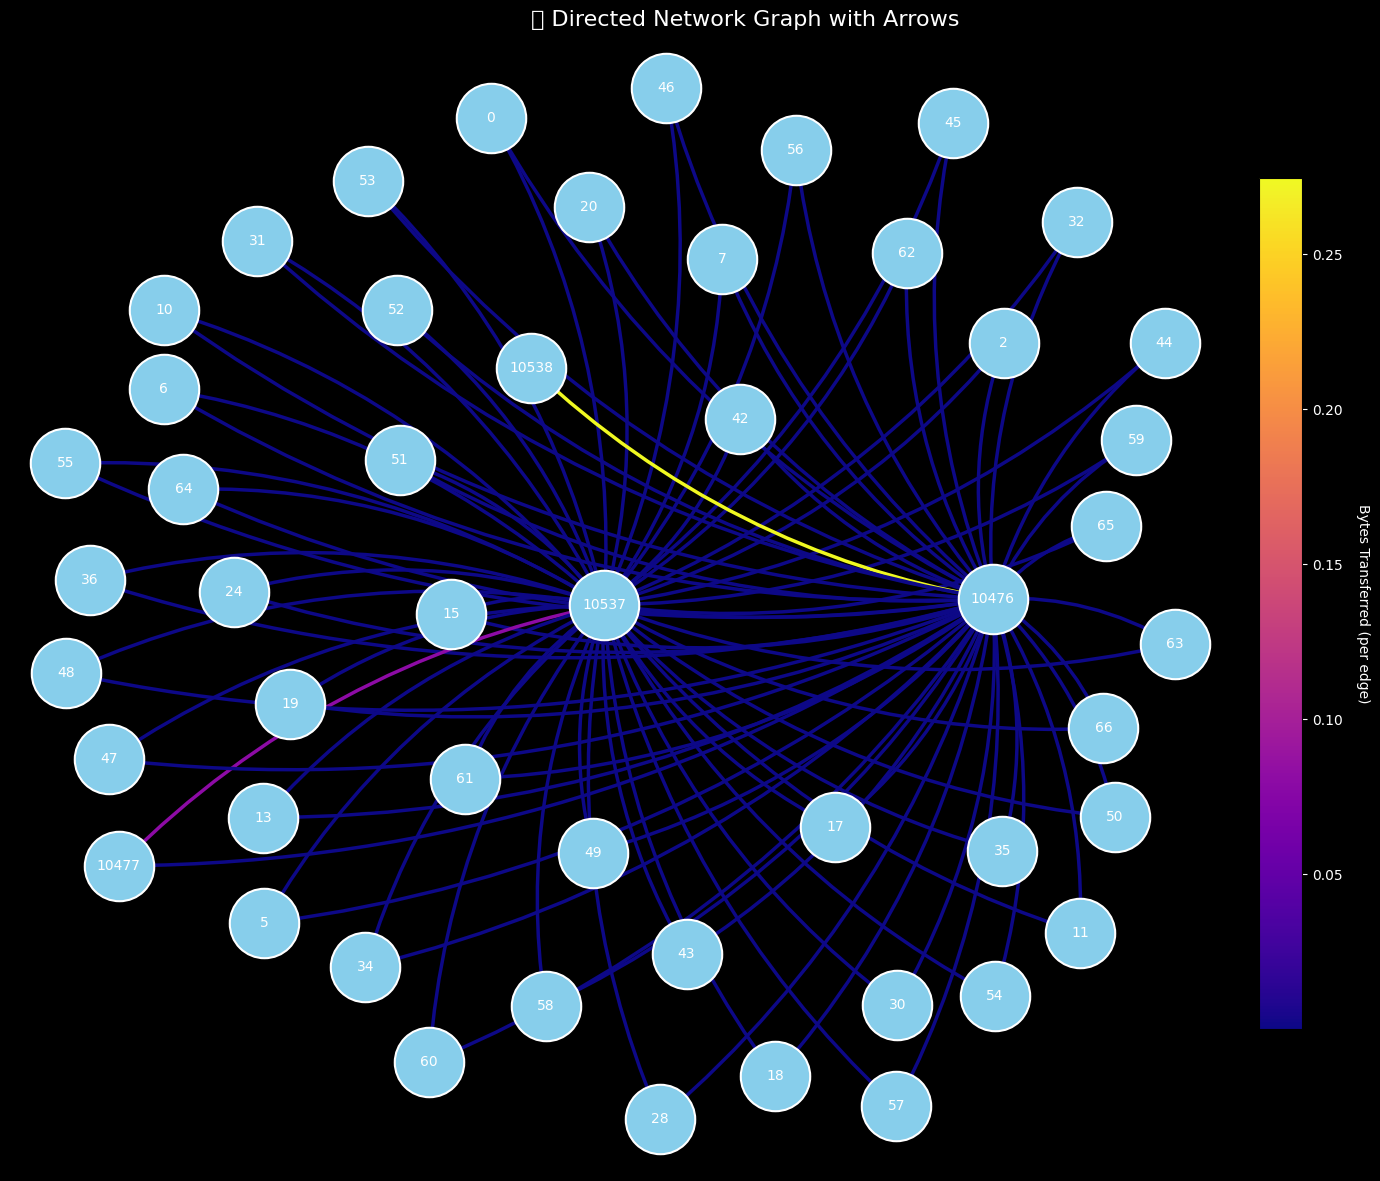

In [125]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import networkx as nx
import numpy as np

# Pick top N nodes by out-degree
top_nodes = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:50]
top_node_ids = [n for n, _ in top_nodes]
H = G.subgraph(top_node_ids)

pos = nx.spring_layout(H, k=0.5, seed=42)

# Normalize edge weights for coloring
edge_weights = [H[u][v].get('bytes', 1) for u, v in H.edges()]
norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [plt.cm.plasma(norm(w)) for w in edge_weights]

# Start plot
fig, ax = plt.subplots(figsize=(15, 12), facecolor='black')
fig.suptitle("🌐 Directed Network Graph with Arrows", fontsize=16, color='white')

# Draw nodes
nx.draw_networkx_nodes(H, pos, node_color="skyblue", edgecolors='white', linewidths=1.5, node_size=2500, ax=ax)
nx.draw_networkx_labels(H, pos, font_color='white', font_size=10, ax=ax)

# Manually draw arrows using FancyArrowPatch
for (u, v), color in zip(H.edges(), edge_colors):
    rad = 0.15  # Curve radius
    arrow = mpatches.FancyArrowPatch(
        posA=pos[u],
        posB=pos[v],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        color=color,
        mutation_scale=18,
        lw=2.5
    )
    ax.add_patch(arrow)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.75, pad=0.02)
cbar.set_label('Bytes Transferred (per edge)', rotation=270, labelpad=20, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

ax.set_facecolor('black')
ax.axis('off')
plt.tight_layout()
plt.show()


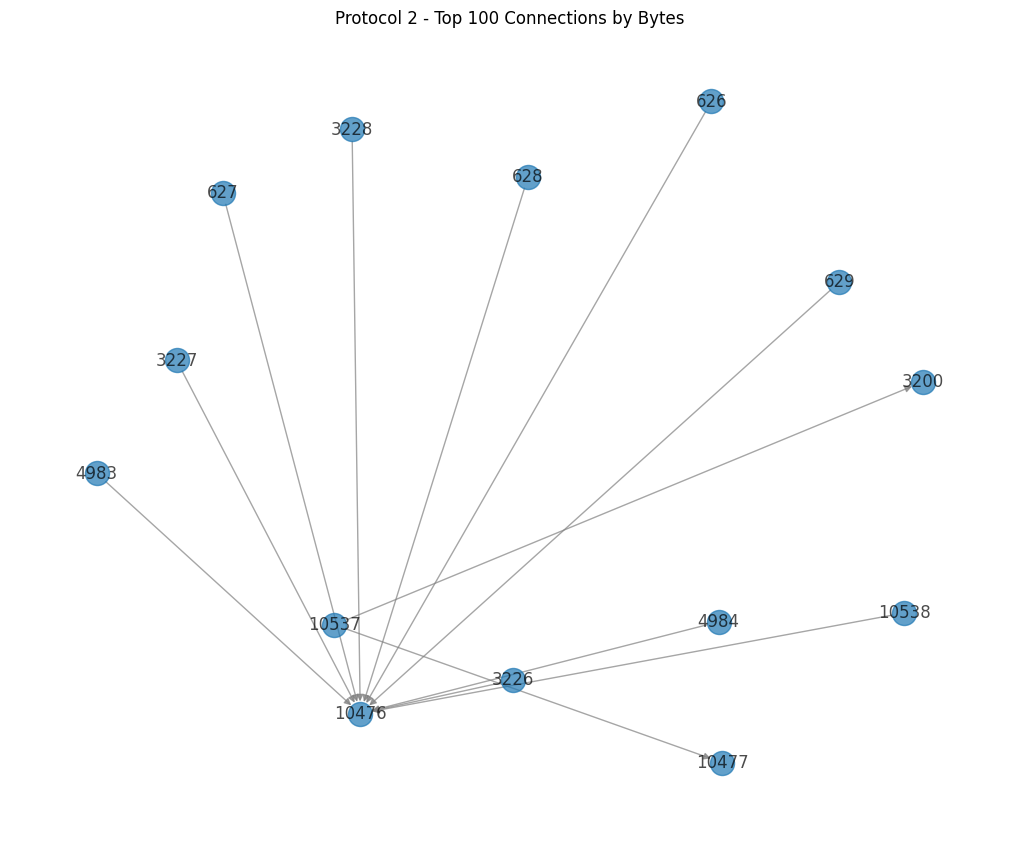

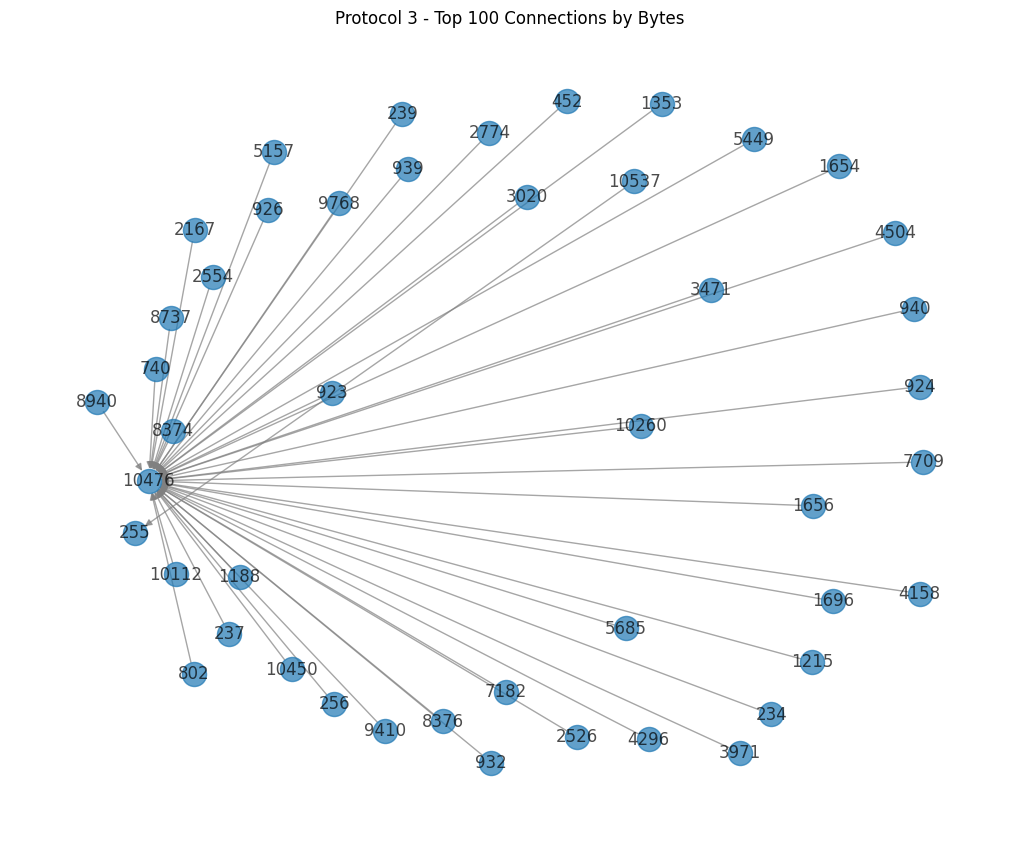

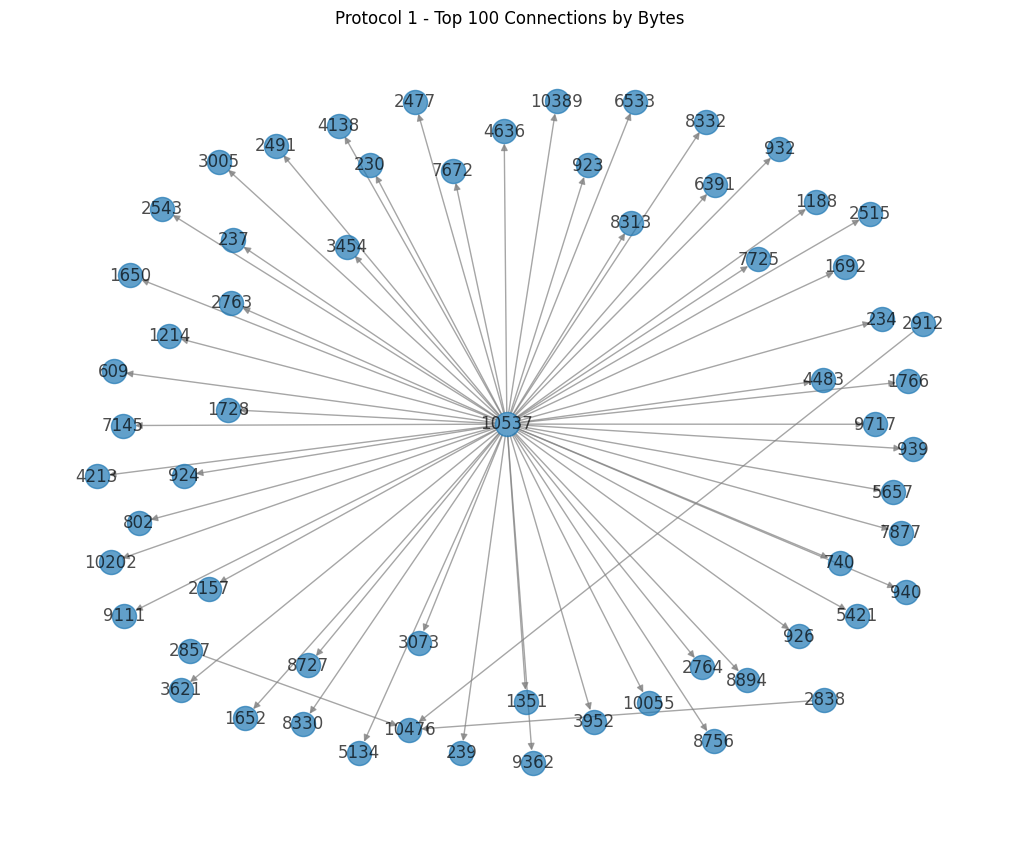

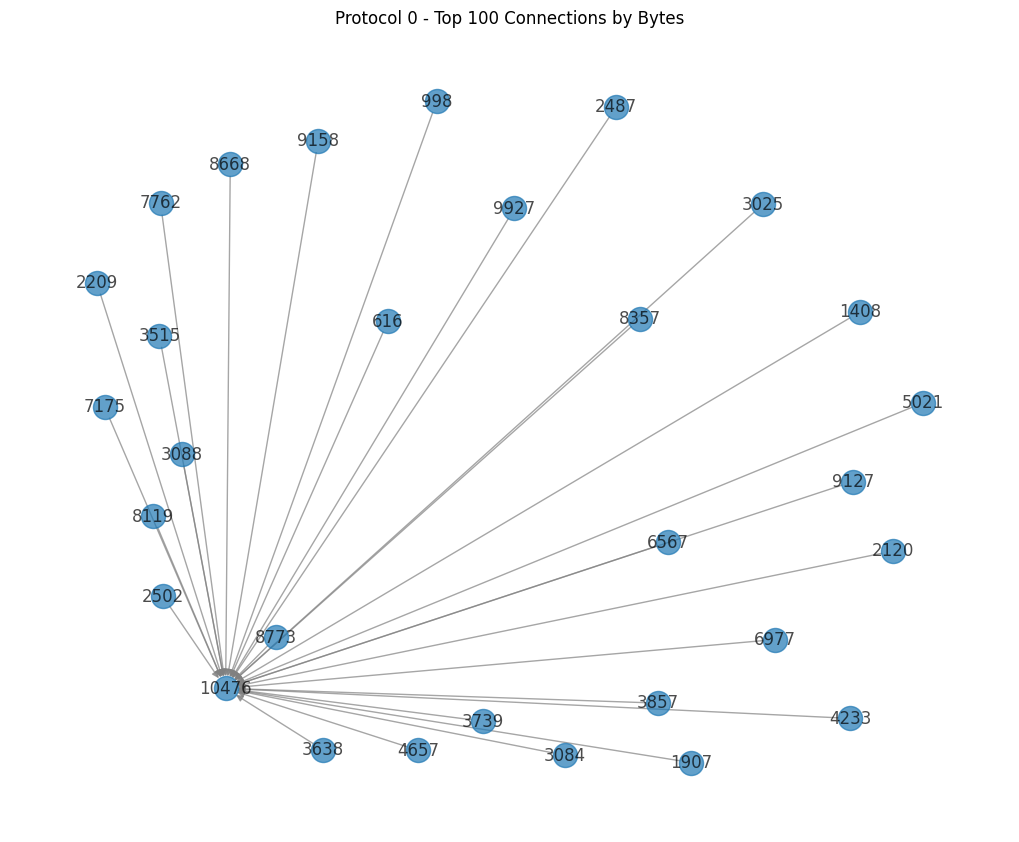

In [134]:
N = 100  # Max number of edges to plot per protocol

for proto in protocols:
    df_proto = df[df['Proto'] == proto].copy()
    df_proto = df_proto.sort_values(by='Bytes', ascending=False).head(N)
    
    G_proto = nx.DiGraph()
    for _, row in df_proto.iterrows():
        src = row['Src IP Addr']
        dst = row['Dst IP Addr']
        edge_data = {
            'bytes': row['Bytes'],
            'packets': row['Packets'],
            'duration': row['Duration']
        }
        G_proto.add_edge(src, dst, **edge_data)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_proto, k=0.8, iterations=20)
    nx.draw(G_proto, pos, with_labels=True, node_size=300, edge_color='gray', alpha=0.7)
    plt.title(f"Protocol {proto} - Top {N} Connections by Bytes")
    plt.show()


In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9921
           1       1.00      1.00      1.00     21469
           2       1.00      1.00      1.00      3178

    accuracy                           1.00     34568
   macro avg       1.00      1.00      1.00     34568
weighted avg       1.00      1.00      1.00     34568

